## Helpsheet to extract and use data from hpf files from the TE77

This file needs 'read_hpf.py' and 'stroke_utils.py' to be in the same folder as it. 
You need the path to the hpf file (hpf_path) and to the bins, which will probably be the same.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from read_hpf import Hpf
from stroke_utils import get_binned_data_from_path, get_expt_info

When 'get_binned_data' is run, it looks first for the bins in the 'bin_path', if it doesn't find them it reports a 'FileNotFoundError' and then gets the data from the hpf file, saves it to bins then reads the data again from the file just to make sure it is there. You will see a 'bins' folder appear in the 'bin_path' if it wasn't already there.

Saving the bins to disc saves an enormous amount of time.

It tries first to look in the spreadsheet to see if it can find the data for the experiment, this should take the form of a csv or excel file with the experiment setting saved as in the file 'Running conditions.xlsx' in the folder in 'WP2'. if the experiment is not there, it ignores it.

it returns a dictionary with each set of data frames saved under an experiment number. 
eg. {'1104_test1_soft_PAO_1_1000-21':data_dfs} where the experiment number (exp_no) is taken from the hpf file name. 

data_dfs is a dicitonary with a set of data frames
e.g. {'ES - right':df, 'ES - left':df, 'Friction - left':df, 'Friction - right':df}
where the df is a data frame with a row for each stroke, indexed by the time it started at in seconds from the start. 

In [2]:
def get_binned_data(hpf_path, bin_path):
    """
    takes in path to hpf file and where the bins ought to be saved.
    looks up the experiment in the spreadsheet, skips it if it is not there.
    returns data dfs. makes checks to ensure info is in exp_info spreadsheet
    """
    exp_dict = {}
    for file in sorted(os.listdir(hpf_path)):
        if '.hpf' not in file:
            continue
        exp_no = file[:-4]
        try: # check to see if i have info, if not don't want this expt.
            spreadsheet_path = os.path.expanduser('~') +'/Data/ping/Tool steel/'
            spreadsheet_name='Running conditions.xlsx'
            exp_info = get_expt_info(exp_no, spreadsheet_path, spreadsheet_name)
        except KeyError:
            print(f'Info for exp {exp_no} not in spreadsheet {spreadsheet_name}')
            continue
        os.makedirs(bin_path, exist_ok=True)

        data_dfs = get_binned_data_from_path(exp_no, hpf_path, bin_path, exp_info)
        exp_dict[exp_no]=data_dfs

    return exp_dict

The next script assumes a folder structure like that in the 'WP2' folder on the shared drive, with all the data in a 'Tool steel' folder, and the files saved in e.g. a 'Test 0630' folder within it. 

The exp_dfs has binned data saved for each hpf file that was in that path. Data that was in channel 1 is automatically 'ES' and channel 2 is 'Friction'. It will throw a key error if there are more channels, unles the 'data_ref dictionary in 'get_bin_dicts' in 'stroke_utils' is edited, and probably a whole load of other stuff would need to be adjusted.

In [3]:
# for day in ['0630', '0707', '0723', '0804', '0805', '0806', '0807', '0811', '0812', '0817', '0818', '0901','0914', '0915', '0916', '1104']:
for day in ['1104']:
    hpf_path = os.path.expanduser('~') +'/Data/ping/Tool steel/Test {}/'.format(day)
    if 'data' in os.listdir(hpf_path): # some have the hpf files in a sub folder data
        hpf_path = hpf_path+'data/'
    bin_path = os.path.expanduser('~') +'/Data/ping/Tool steel/Test {}/bins/'.format(day)
    exp_dfs = get_binned_data(hpf_path, bin_path)
    for exp_no in exp_dfs.keys(): # iterates through the experiment
        data_df = exp_dfs[exp_no] # gets data for expt
        for key in data_df.keys(): # looks at the data for each key
            df = data_df[key]
            print(exp_no, key, df.shape) # tells you about the data
            
    

load is list ['40', '80', '120', '160', '200', '240', '280', '320', '360', '400'] for expt. 1104_test1_soft_PAO_1_1000-21, chosing 240.0
1104_test1_soft_PAO_1_1000-21 Friction Adjustment (N/V) 10
1104_test1_soft_PAO_1_1000-21 Charge amp adjustment (pC/V) 1.0
1104_test1_soft_PAO_1_1000-21
in read bin dicts from file
read 1104_test1_soft_PAO_1_1000-21 from file /Users/jojo/Data/ping/Tool steel/Test 1104/bins/
load is list ['40', '80', '120', '160'] for expt. 1104_test4_soft_PAO_heat_1_1000-5, chosing 120.0
1104_test4_soft_PAO_heat_1_1000-5 Friction Adjustment (N/V) 10
1104_test4_soft_PAO_heat_1_1000-5 Charge amp adjustment (pC/V) 1.0
1104_test4_soft_PAO_heat_1_1000-5
in read bin dicts from file
read 1104_test4_soft_PAO_heat_1_1000-5 from file /Users/jojo/Data/ping/Tool steel/Test 1104/bins/
1104_test1_soft_PAO_1_1000-21 Friction - left (3121, 100)
1104_test1_soft_PAO_1_1000-21 Friction - right (3121, 100)
1104_test1_soft_PAO_1_1000-21 ES - left (3121, 100)
1104_test1_soft_PAO_1_1000-21 E

To do outlier detection on the binned data, i concatenated the right and left values to make a set of vectors 200 long, and used those as my samples. 

In [4]:
exp_concat_df = {}
for exp_no in exp_dfs.keys():
    data_df = exp_dfs[exp_no]
    es_df = data_df['ES - left'].join(data_df['ES - right'], 
                                      lsuffix = ' left', 
                                      rsuffix = ' right')
    fr_df = data_df['Friction - left'].join(data_df['Friction - right'], 
                                      lsuffix = ' left', 
                                      rsuffix = ' right')
    print(es_df.head())
    print(fr_df.head())
    exp_concat_df[exp_no]=(es_df, fr_df)
    
            
        

        -5.7 left  -5.45 left  -5.2 left  -4.95 left  -4.7 left  -4.45 left  \
time                                                                          
0.008    0.459595    0.458233   0.455825    0.450521   0.443115    0.442116   
38.164   0.377734    0.375000   0.371094    0.361704   0.353516    0.343750   
39.703   0.387441    0.380859   0.372221    0.371538   0.357422    0.355835   
41.099   0.390837    0.386827   0.380108    0.375000   0.368042    0.361328   
42.391   0.392748    0.390625   0.380859    0.378418   0.367606    0.362413   

        -4.2 left  -3.95 left  -3.7 left  -3.45 left  ...  16.8 right  \
time                                                  ...               
0.008    0.429688    0.422852   0.408325    0.405273  ...   -0.227051   
38.164   0.335083    0.321568   0.317383    0.304688  ...   -0.293457   
39.703   0.339966    0.334124   0.322876    0.308315  ...   -0.307617   
41.099   0.348075    0.332031   0.328544    0.313314  ...   -0.292271   
42.391  

You now have a full set of binned data you can use. should you wish to do outlier detection on it, you will need to install the library 'odds' via 'pip install odds' in your virtual environment. 

In [5]:
from odds import OD

Be warned, this can be very slow for large data sets and algorithms like LSTM, AE

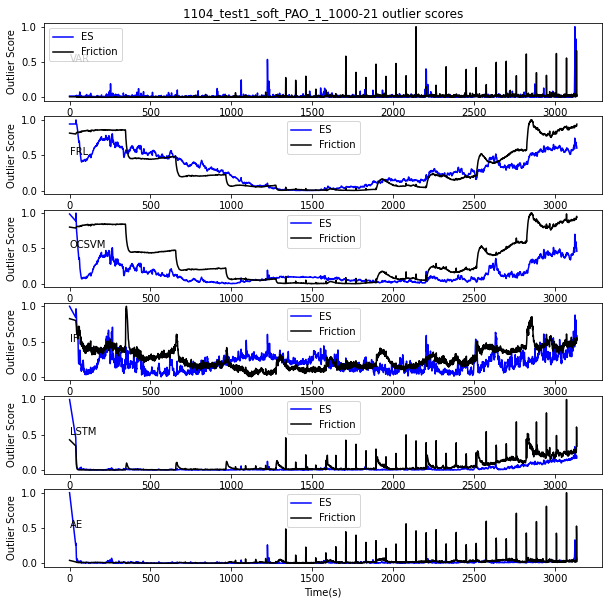

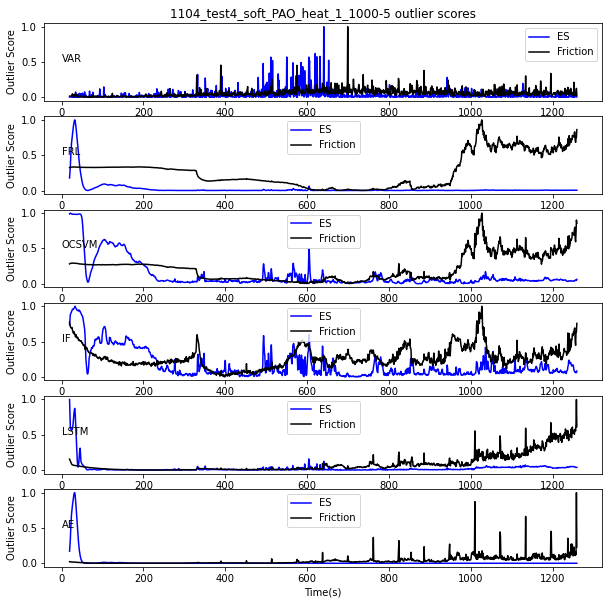

In [11]:
full_algo_list = ['VAR', 'FRO', 'FRL', 'FRR', 'OCSVM', 'DBSCAN', 'GMM', 'IF', 'LSTM','GRU', 'AE', 'VAE', 'OP', 'GOP','RAND']
short_algo_lst = ['VAR', 'FRL', 'OCSVM', 'IF', 'LSTM', 'AE']
algo_lst = short_algo_lst

for exp_no in exp_concat_df.keys():
    #makes the directory to save the plots
    os.makedirs("./{}/images/".format(exp_no), exist_ok=True)
    es_df, fr_df = exp_concat_df[exp_no]
    es_matrix = es_df.values # gets just the numbers out of the data frames
    fr_matrix = fr_df.values
    plt.figure(figsize=(10,10))
    
    for i in range(len(algo_lst)):
        algo = algo_lst[i]
        od = OD(algo)
        es_outlier_scores = od.get_os(es_matrix, norm=True)
        fr_outlier_scores = od.get_os(fr_matrix, norm=True)
        plt.subplot(len(algo_lst), 1, i+1)
        if i ==0:
            plt.title(f'{exp_no} outlier scores')
        elif i+1 == len(algo_lst):
            plt.xlabel('Time(s)')
        plt.plot(es_df.index, es_outlier_scores, 'b', label='ES')
        plt.plot(fr_df.index, fr_outlier_scores, 'k', label='Friction')
#         plt.xlabel('Time (s)')
        plt.ylabel('Outlier Score')
        plt.annotate(algo, (0,0.5))
        plt.legend()
    plt.savefig(f'./{exp_no}/images/{exp_no}_outlier_scores.png')
    plt.show()


To plot the strokes for a particular experiment, here we will use the exp_dfs dictionary we read from the bins files earlier. 

1104_test1_soft_PAO_1_1000-21


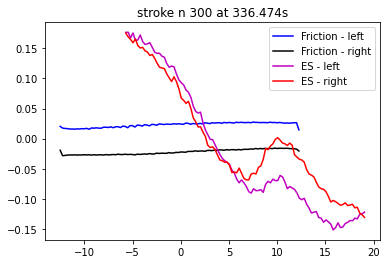

1104_test4_soft_PAO_heat_1_1000-5


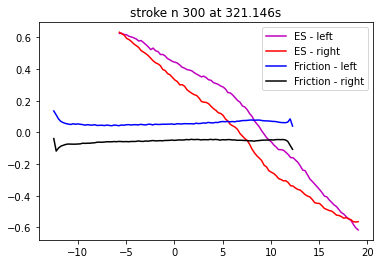

In [12]:
stroke_n = 300
r_max = 12.5

for exp_no in exp_dfs.keys():
    data_dfs = exp_dfs[exp_no]
    print(exp_no)
    for key in data_dfs.keys():
        df = data_dfs[key]
        stroke = df.iloc[stroke_n]
        col_dict = {'ES - left':'m', 'ES - right':'r', 'Friction - left':'b', 'Friction - right':'k'} 
        plt.plot(df.columns.astype('float'), stroke, col_dict[key], label=key)
        plt.title(f'stroke n {stroke_n} at {stroke.name}s')
        plt.legend()
    plt.show()

To find the strokes for a particular time, we need to find a close time, using the index of the data frame.

1104_test1_soft_PAO_1_1000-21


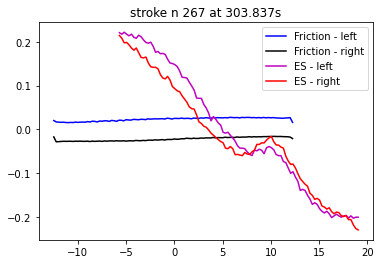

1104_test4_soft_PAO_heat_1_1000-5


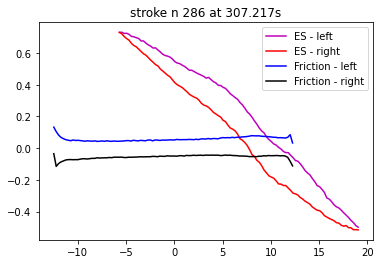

In [13]:
stroke_t = 300

def get_time(time, df):
    """
    data frame has time as index and displacement as columns
    returns the nearest time down from the given time
    """
    for i in range(len(df.index)):
#         print(time_ind)
        if time < df.index[i]:
            return df.index[i], i

    
for exp_no in exp_dfs.keys():

    data_dfs = exp_dfs[exp_no]
    print(exp_no)
    for key in data_dfs.keys():
        
        df = data_dfs[key]
        stroke_t, stroke_n = get_time(stroke_t, df)
        stroke = df.loc[stroke_t]
        col_dict = {'ES - left':'m', 'ES - right':'r', 'Friction - left':'b', 'Friction - right':'k'} 
        plt.plot(df.columns.astype('float'), stroke, col_dict[key], label=key)
        plt.title(f'stroke n {stroke_n} at {stroke.name}s')
        plt.legend()
    plt.show()

To plot the stroke for each easier to make a function to call

In [14]:
def plot_strokes(df_dict, dir_name, inds=None, save_name=False, show=False):
    """
    plots lines using colours in col_dict. 
    """
    r_max = 12.5
    min_disp = -12.5
    span = 0.5

    col_dict = {'ES - left':'m', 'ES - right':'r', 'Friction - left':'b', 'Friction - right':'k'} 
    t_lst = list(df_dict['ES - left'].index)
    for stroke_n in range(len(t_lst)):
        #for each stroke if inds is None
        if inds: # for only strokes listed in inds
            if stroke_n not in inds:
                continue
        plt.figure()
        plt.axvspan(min_disp, r_max, facecolor='c', alpha=0.2)
        plt.axvspan(r_max-span, r_max+span, facecolor='c', alpha=0.1)
        plt.grid()
        max_y = 0.5
        plt.axis([-12.5, 18.5, -0.5, 0.5])
        plt.axvline(x=r_max, color='r', linestyle='--')
        plt.axvline(x=-r_max, color='r', linestyle='--')
        for key in df_dict.keys():
            df = df_dict[key]
            displacements = df.columns.astype('float')
            data = df.iloc[stroke_n]
            plt.plot(displacements, data, col_dict[key], label=key)
        plt.title(f'stroke n {stroke_n} at {data.name}s')
        plt.legend()
        if save_name:
            #makes the directory to save the plots
            os.makedirs("./{}/{}/".format(exp_no, dir_name), exist_ok=True)
            plt.savefig(f'./{exp_no}/{dir_name}/{save_name}_{stroke_n:04}.png')
        if show:
            plt.show()
#         raise


Then call it for each experiment, so it can iterate through and plot a stroke for each stroke number, or if you specify the inds, only the indexes you specify

In [15]:
for exp_no in exp_dfs.keys():
    print(exp_no)

    data_dfs = exp_dfs[exp_no]
    inds = list(np.arange(0,n,100))
    plot_strokes(data_dfs, 'stroke_plots', inds=inds, save_name=exp_no, show=True)

1104_test1_soft_PAO_1_1000-21


NameError: name 'n' is not defined

to plot the differences between each stroke, 

In [ ]:
for exp_no in exp_dfs.keys():
    print(exp_no)

    data_dfs = exp_dfs[exp_no]
    #make diff of data
    diff_dfs={}
    for key in data_dfs.keys():
        df = data_dfs[key]
        n,p = df.shape
        diffs = df.diff()#.dropna(inplace=True)
        diffs = diffs.dropna()
        diff_dfs[key]=diffs
    inds = list(np.arange(0,n,100))
    plot_strokes(diff_dfs, 'diff_stroke_plots', inds=inds, save_name=exp_no, show=True)

You can make a video of these images. You need the image library cv2, which you can install via pip install opencv-python in your virtual environment if you don't have it

In [ ]:
import cv2

In [ ]:
def make_vid(img_path, exp_no, note):
    """
    takes path to a folder of images, makes a video sequence based on them
    """
    im_lst = []
    for img_name in sorted(os.listdir(img_path)):
#         print(img_name)
        if '.DS_Store' in img_name :
            continue
        img = cv2.imread(img_path+img_name)
        height, width, layers = img.shape
        size = (width*2, height*2)
        im_lst.append(img)

    out_vid = cv2.VideoWriter(f'{exp_no}_{note}.avi', cv2.VideoWriter_fourcc(*'MJPG'), 15, size)

    for img in range(len(im_lst)):
        out_vid.write(im_lst[img])

    out_vid.release()

The openCV python library can be used to make the video files

In [92]:
for exp_no in exp_dfs.keys():
    note = 'diff'
    dir_name = 'diff_stroke_plots'
    img_path = f"./{exp_no}/{dir_name}/"
    make_vid(img_path, exp_no, note)
    fname = f'{exp_no}_{note}.avi'
    Video(fname)

Unfortunately it seems difficult to display '.avi' files in jupyter notebook

In [ ]:
from IPython.display import Video
for exp_no in exp_dfs.keys():
    note = 'diff'
    fname = f'{exp_no}_{note}.avi'
    Video(fname)

In [112]:
for exp_no in exp_dfs.keys():
    note = 'raw'
    dir_name = 'stroke_plots'
    img_path = f"./{exp_no}/{dir_name}/"
    make_vid(img_path, exp_no, note)
    fname = f'{exp_no}_{note}.avi'
    Video(fname)

In [ ]:
for exp_no in exp_dfs.keys():
    note = 'raw'
    fname = f'{exp_no}_{note}.avi'
    Video(fname)

To plot values at certain displacements, you just need to plot the values down a certain column. 

1104_test1_soft_PAO_1_1000-21
Friction - left -4.75
Friction - left 0.0
Friction - left 5.0
Friction - left 12.25


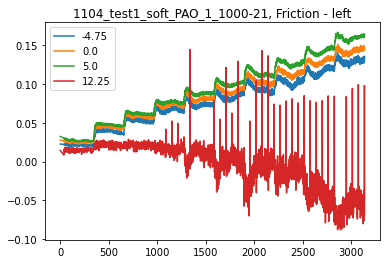

Friction - right -4.75
Friction - right 0.0
Friction - right 5.0
Friction - right 12.25


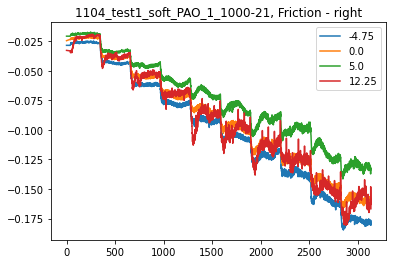

ES - left -4.7
ES - left 0.05
ES - left 5.05
ES - left 12.3


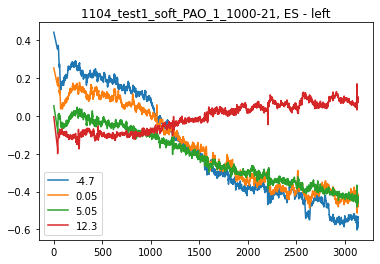

ES - right -4.7
ES - right 0.05
ES - right 5.05
ES - right 12.3


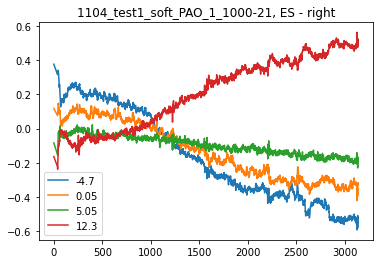

1104_test4_soft_PAO_heat_1_1000-5
ES - left -4.7
ES - left 0.05
ES - left 5.05
ES - left 12.3


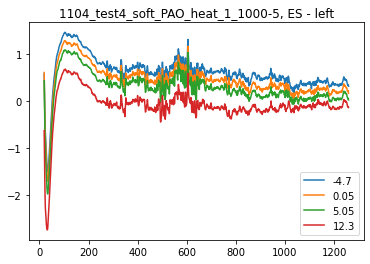

ES - right -4.7
ES - right 0.05
ES - right 5.05
ES - right 12.3


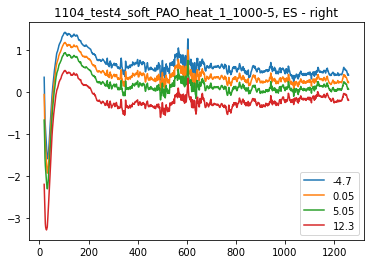

Friction - left -4.75
Friction - left 0.0
Friction - left 5.0
Friction - left 12.25


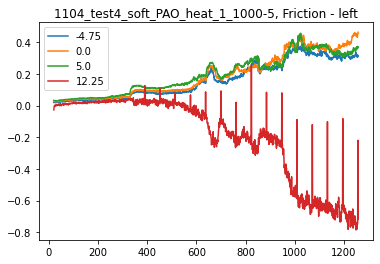

Friction - right -4.75
Friction - right 0.0
Friction - right 5.0
Friction - right 12.25


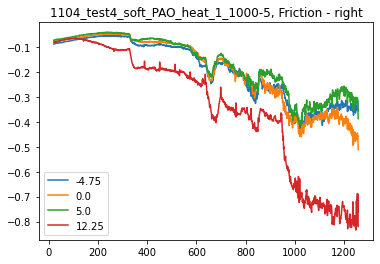

In [7]:

fdisp=['-4.75', '0.0', '5.0', '12.25']
edisp=['-4.7', '0.05', '5.05', '12.3']
for exp_no in exp_dfs.keys():
    print(exp_no)

    data_dfs = exp_dfs[exp_no]
    for key in data_dfs.keys():
        df = data_dfs[key]
        if 'ES' in key:
            disp = edisp
            
        else:
            disp=fdisp
        for d in disp:
            print(key, d)
            data = df[d]
            plt.plot(df.index.astype('float'), data, label=d)
        plt.title(f'{exp_no}, {key}')
        plt.legend()
        plt.show()